In [1]:
# notebook.ipynb
import json
import joblib
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Load metadata
df = pd.read_csv('data/sample_labels.csv')
print("Total entries:", len(df))

Total entries: 5606


In [3]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [4]:
df["Finding Labels"] = df["Finding Labels"].replace("No Finding", "") # Replace 'No Finding' with empty string for multi-hot encoding

In [5]:
df["labels"] = df["Finding Labels"].str.split("|") # split labels (|) and create a new columns for them (list)

In [6]:
df["labels"] = df["labels"].apply(lambda x: [label for label in x if label != ""])

In [7]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,labels
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,"[Emphysema, Infiltration, Pleural_Thickening, ..."
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,"[Cardiomegaly, Emphysema]"
2,00000017_001.png,,1,17,077Y,M,AP,2500,2048,0.168,0.168,[]
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,[Atelectasis]
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,"[Cardiomegaly, Edema, Effusion]"


In [8]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["labels"])
label_names = mlb.classes_

In [9]:
print(f"Classes: {list(label_names)}")

Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [10]:
joblib.dump(mlb, "mlb_classes.pkl")  # Save for later use

['mlb_classes.pkl']

In [11]:
len(label_names) # 14 pathologies

14

In [12]:
# df["labels"].loc[0] -> ['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax']
# labels[0] -> [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
#Classes: ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
#labels[0]

In [13]:
for i, name in enumerate(label_names): # Add encoded labels to df
    df[name] = labels[:, i] # takes an entire columns of the labels matrix -> all rows of the ith column

In [14]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0,1,0,0,1,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
2,00000017_001.png,,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0


In [15]:
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=22) # Train/val split

In [16]:
pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Create stratified split (1 fold for val)
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=22)
for train_idx, val_idx in mskf.split(df, labels):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    break  # just take the first split


In [18]:
# Build Dataset Class
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.labels = dataframe[label_names].values
        self.image_names = dataframe["Image Index"].values #all values in the "Image Index" column

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx): 
        image_path = os.path.join(self.image_dir, self.image_names[idx]) 
        image = Image.open(image_path).convert("RGB")                                               # df["labels"].loc[0] -> ['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax']
        label = torch.FloatTensor(self.labels[idx]) #the labels of the current index as a float tensor e.g. df[labels_name].values[0] -> array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])
    
        if self.transform: 
            image = self.transform(image)

        return image, label

In [19]:
#Image Transforms and Loaders
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # mild for chest X-rays
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], #The mean and standard deviation of each color channel (R, G, B) across all ImageNet training images. -> normalized_pixel = (pixel - mean) / std
                         [0.229, 0.224, 0.225])
])

train_ds = ChestXrayDataset(train_df, "data/images", transform=train_transform)
val_ds = ChestXrayDataset(val_df, "data/images", transform=transform)    

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

In [20]:
# Define the Model
def get_model(num_classes=14, freeze_backbone=False): 
    model = models.resnet50(pretrained=True)

     # Freeze base layers (optional: for faster training initially)
    if freeze_backbone:
        for param in model.parameters(): 
            param.requires_grad = False # Set to False if you want to freeze

    model.fc = nn.Linear(model.fc.in_features, num_classes) # Replace final FC layer for multilabel classification

    return model

In [21]:
# Define Loss, Optimizer, Metrics 
# Multilabel classification needs a sigmoid + BCE loss — we use: nn.BCEWithLogitsLoss()

In [22]:
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

In [23]:
model = get_model(num_classes=len(label_names)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [24]:
# Training Loop
from sklearn.metrics import roc_auc_score

def train_one_epoch(model, loader, optimizer, criterion, scaler): 
    model.train()
    total_loss = 0

    #print("train_one_epoch:")
    
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #loss.backward()
        #optimizer.step()

        total_loss += loss.detach().item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion): 
    model.eval()
    total_loss = 0
    all_labels = []
    all_outputs = []

    print("validate")
    
    for images, labels in tqdm(loader): 
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.detach().item()
    
        all_labels.append(labels.cpu())
        all_outputs.append(torch.sigmoid(outputs).cpu())

    all_labels = torch.cat(all_labels)
    all_outputs = torch.cat(all_outputs)

    #AUROC per class 
    aurocs = []
    for i in range(all_labels.shape[1]): 
        try:
            auc = roc_auc_score(all_labels[:,i], all_outputs[:,i])
            aurocs.append(auc)
        except ValueError:
            aurocs.append(float("nan")) # if only one class present

    macro_auroc = np.nanmean(aurocs) # average across valid classes
    
    return total_loss / len(loader), aurocs, macro_auroc

In [25]:
####################

In [82]:
##########STOP

In [83]:
# Run training 
EPOCHS = 5

train_losses = []
val_losses = []
val_aurocs = []
best_macro_auroc = 0
best_epoch = 0
patience = 5
no_improve_epochs = 0

for epoch in range(EPOCHS): 
    print(f"Starting Epoch {epoch}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_auc, macro = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aurocs.append(val_auc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val AUROC (mean): {macro:.4f}")

    if macro > best_macro_auroc:
        best_macro_auroc = macro
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pth")

        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_aurocs': val_aurocs,
            'best_macro_auroc': best_macro_auroc
        }
        torch.save(checkpoint, "checkpoint_best.pth")

        print(f"\nBest model saved from epoch {best_epoch} with macro AUROC: {best_macro_auroc:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

with open("training_log.json", "w") as f:
    json.dump({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_aurocs": val_aurocs
    }, f)

        

Starting Epoch 0


100%|██████████| 141/141 [02:24<00:00,  1.03s/it]


validate


100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


Epoch 1/5
Train Loss: 0.2102 | Val Loss: 0.1660
Val AUROC (mean): 0.7192

Best model saved from epoch 1 with macro AUROC: 0.7192
Starting Epoch 1


100%|██████████| 141/141 [01:53<00:00,  1.24it/s]


validate


100%|██████████| 36/36 [00:25<00:00,  1.39it/s]


Epoch 2/5
Train Loss: 0.1618 | Val Loss: 0.1604
Val AUROC (mean): 0.7361

Best model saved from epoch 2 with macro AUROC: 0.7361
Starting Epoch 2


100%|██████████| 141/141 [02:08<00:00,  1.10it/s]


validate


100%|██████████| 36/36 [00:28<00:00,  1.27it/s]


Epoch 3/5
Train Loss: 0.1556 | Val Loss: 0.1615
Val AUROC (mean): 0.7380

Best model saved from epoch 3 with macro AUROC: 0.7380
Starting Epoch 3


100%|██████████| 141/141 [02:03<00:00,  1.14it/s]


validate


100%|██████████| 36/36 [00:25<00:00,  1.40it/s]


Epoch 4/5
Train Loss: 0.1497 | Val Loss: 0.1616
Val AUROC (mean): 0.7374
Starting Epoch 4


100%|██████████| 141/141 [01:52<00:00,  1.25it/s]


validate


100%|██████████| 36/36 [00:25<00:00,  1.42it/s]


Epoch 5/5
Train Loss: 0.1428 | Val Loss: 0.1649
Val AUROC (mean): 0.7726

Best model saved from epoch 5 with macro AUROC: 0.7726


In [ ]:
"""

python train.py \
  --csv data/sample_labels.csv \
  --image_dir data/images \
  --epochs 30 \
  --batch_size 32 \
  --lr 1e-4 \
  --workers 4 \
  --patience 5



"""

In [ ]:
############## EValuation

In [26]:
# Load the MultiLabelBinarizer object
mlb = joblib.load("mlb_classes.pkl")
label_names = mlb.classes_

In [27]:
label_names

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [28]:
model = get_model(num_classes=len(label_names)).to(device)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
# load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [541]:
def predict_image(model, image_tensor, threshold=0.25, device=None):
    """
    Predict labels for a single image tensor using a multi-label classifier.
    
    Args:
        model: Trained PyTorch model.
        image_tensor: Tensor of shape [3, H, W] (single image).
        threshold: Sigmoid threshold for binary label assignment.
        device: torch.device object or None (auto-detect if None).
        
    Returns:
        prediction_labels: Tensor of binary predictions (0 or 1).
        prediction_probs: Tensor of probabilities after sigmoid.
    """
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)
    
    input_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dim
    
    with torch.no_grad(): 
        output = model(input_tensor) # image at index 0
        prediction = torch.sigmoid(output)
        prediction_labels = (prediction > threshold).int()

    return prediction_labels, prediction[0]

In [542]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def denormalize(tensor, mean, std):
    # Clone so we don't change original tensor
    result = tensor.clone()
    for t, m, s in zip(result, mean, std):
        t.mul_(s).add_(m)
    return result

def cam_img(model, image_tensor, target_class_idx, use_cuda=True):
    """
    Generate a Grad-CAM heatmap for a single image and class index.

    Args:
        model: The trained PyTorch model (e.g., ResNet50).
        image_tensor: A single image tensor [3, H, W] (not batched).
        target_class_idx: Integer index of the target class.
        use_cuda: Whether to use GPU if available.

    Returns:
        cam_image: Numpy array of CAM heatmap overlay (RGB).
        target_class_idx: The class index used.
    """

    device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")
    model.to(device).eval()

    input_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dim
    
    # Pick the layer to visualize
    target_layer = model.layer4[-1]  # Last conv layer in ResNet50
    
    # Initialize GradCAM object
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Choose class index 
    targets = [ClassifierOutputTarget(target_class_idx)]
    
    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0]  # Remove batch dimension
    
    img_denorm = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_rgb = img_denorm.permute(1, 2, 0).cpu().numpy()
    img_rgb = np.clip(img_rgb, 0, 1)
    
    # Create CAM overlay
    cam_image = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
    
    return cam_image, target_class_idx


In [543]:
#Select one image by index

image_number = 4
image_tensor, label_tensor = val_ds[image_number][0], val_ds[image_number][1]  # returns transformed image and label

In [544]:
predicted_labels, pred_proba = predict_image(model, image_tensor)

# Decode
decoded_true_labels = mlb.inverse_transform(label_tensor.unsqueeze(0).cpu().numpy())
decoded_labels = mlb.inverse_transform(predicted_labels.cpu().numpy())

print(f"Predicted Labels: {decoded_true_labels}")
print(f"True labels: {label_tensor}")
print(f"Predicted labels: {predicted_labels}")
print(f"Predicted labels probability: {pred_proba}")

print(f"Predicted Labels: {decoded_labels}")

Predicted Labels: [('Effusion',)]
True labels: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Predicted labels: tensor([[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.int32)
Predicted labels probability: tensor([0.4625, 0.0859, 0.1996, 0.0458, 0.7628, 0.0226, 0.0251, 0.0124, 0.2765,
        0.0601, 0.0647, 0.0791, 0.0246, 0.0387], device='cuda:0')
Predicted Labels: [('Atelectasis', 'Effusion', 'Infiltration')]


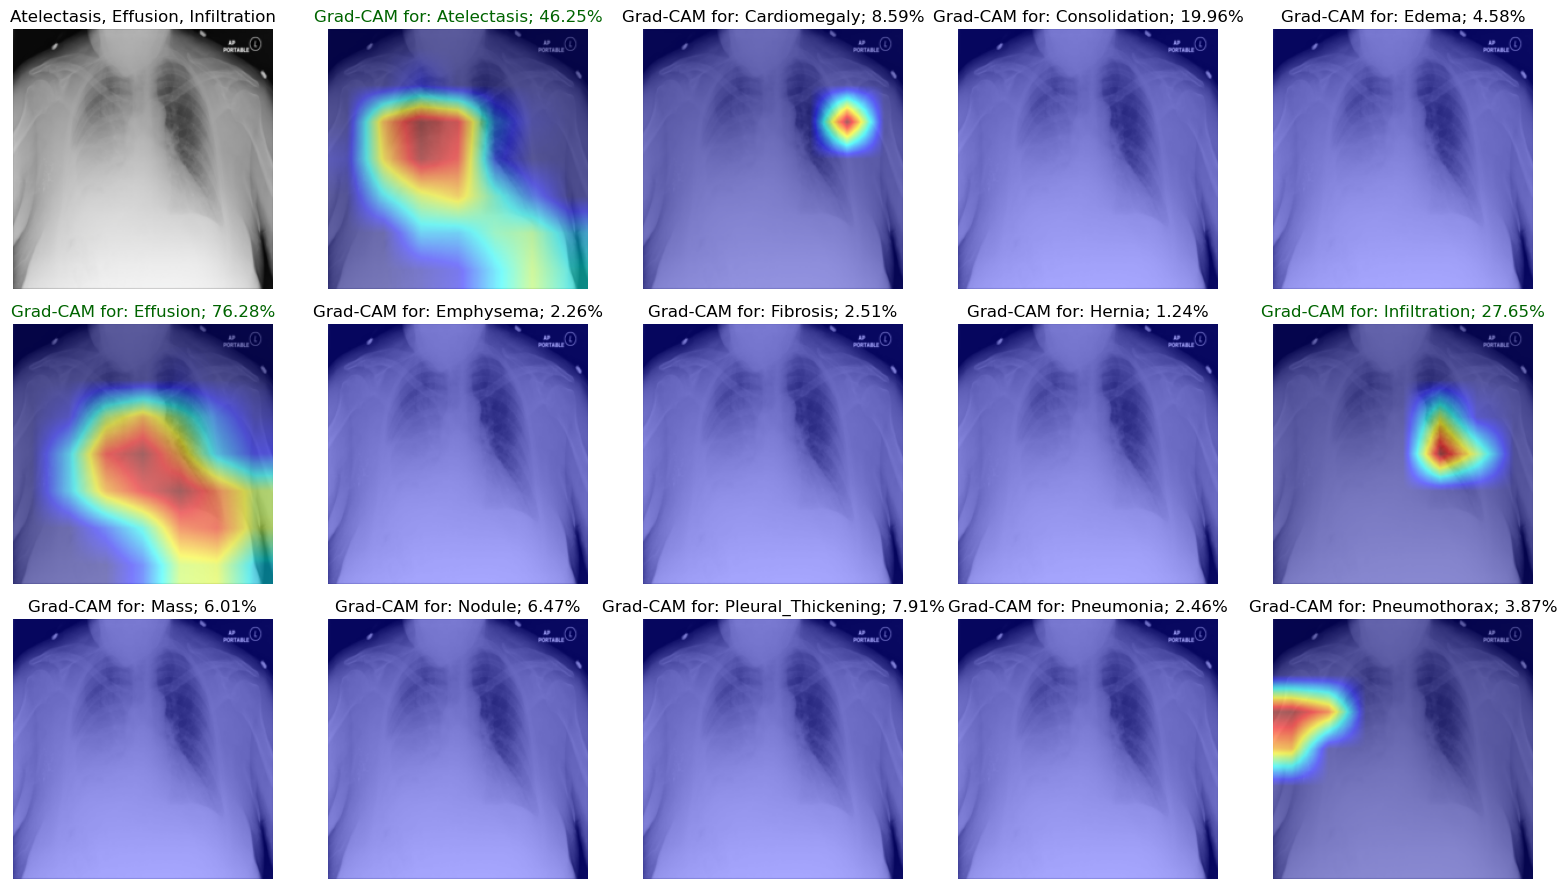

In [550]:
rows, cols = 3, 5
fig = plt.figure(figsize=(16,9))

for i in range(rows*cols):
    plt.subplot(rows, cols, i + 1)

    if i == 0:
        img_denorm = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img_np = img_denorm.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        plt.imshow(img_np)
        plt.axis('off')
        plt.title(", ".join(decoded_labels[0]))

    else:

        is_pred = predicted_labels[0, i-1].item() == 1
        prob = float(pred_proba[i-1])
    
        img, target_class = cam_img(model, image_tensor, i-1)
        plt.imshow(img)
        plt.axis("off")
        title = f"{label_names[target_class]}; {prob *100:.2f}%"
        color = "darkgreen" if is_pred else "black"
        plt.title(f"Grad-CAM for: {title}", color=color)
        

plt.tight_layout()

plt.savefig("figure.png", dpi=300)
plt.show()
